In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, random_state=0):
    
    np.random.seed(random_state)
    x = np.zeros((datanum, 10))
    for i in range(10):
        x[:, i:i+1] = np.random.uniform(0, 1,[datanum,1])
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = [x[:, [i]] for i in range(10)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
         + 0.1 * np.exp(-8 * x2 + 4)
         + 3 * np.sin(2 * np.pi * x3 * x4)
         + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X1":{"type":'continuous'},
             'X2':{'type':'continuous'},
             'X3':{'type':'continuous'},
             'X4':{'type':'continuous'},
             'X5':{'type':'continuous'},
             'X6':{'type':'continuous'},
             'X7':{'type':'continuous'},
             'X8':{'type':'continuous'},
             'X9':{'type':'continuous'},
             'X10':{'type':'continuous'},
             'Y':{'type':'target'}}
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=5000, random_state=0)

## Train GAMI-Net 

In [3]:
model = GAMINet(meta_info=meta_info, interact_num=20, interact_arch=[20, 10],
            subnet_arch=[20, 10], task_type=task_type, activation_func=tf.tanh, main_grid_size=41, interact_grid_size=41,
            batch_size=min(500, int(0.2*train_x.shape[0])), lr_bp=0.001, main_effect_epochs=2000,
            interaction_epochs=2000, tuning_epochs=50, loss_threshold=0.01,
            verbose=True, val_ratio=0.2, early_stop_thres=100)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.13117, val loss: 0.13101
Main effects training epoch: 2, train loss: 0.12540, val loss: 0.12523
Main effects training epoch: 3, train loss: 0.12052, val loss: 0.12037
Main effects training epoch: 4, train loss: 0.11592, val loss: 0.11590
Main effects training epoch: 5, train loss: 0.11178, val loss: 0.11174
Main effects training epoch: 6, train loss: 0.10781, val loss: 0.10770
Main effects training epoch: 7, train loss: 0.10394, val loss: 0.10392
Main effects training epoch: 8, train loss: 0.10021, val loss: 0.10031
Main effects training epoch: 9, train loss: 0.09677, val loss: 0.09690
Main effects training epoch: 10, train loss: 0.09353, val loss: 0.09369
Main effects training epoch: 11, train loss: 0.09005, val loss: 0.09022
Main effects training epoch: 12, train loss: 0.08719, val loss: 0.08743
Main effects training e

Main effects training epoch: 114, train loss: 0.01008, val loss: 0.01000
Main effects training epoch: 115, train loss: 0.01007, val loss: 0.00997
Main effects training epoch: 116, train loss: 0.01004, val loss: 0.00991
Main effects training epoch: 117, train loss: 0.01002, val loss: 0.00991
Main effects training epoch: 118, train loss: 0.01003, val loss: 0.00996
Main effects training epoch: 119, train loss: 0.01001, val loss: 0.00991
Main effects training epoch: 120, train loss: 0.00997, val loss: 0.00985
Main effects training epoch: 121, train loss: 0.01007, val loss: 0.00998
Main effects training epoch: 122, train loss: 0.00998, val loss: 0.00987
Main effects training epoch: 123, train loss: 0.00994, val loss: 0.00983
Main effects training epoch: 124, train loss: 0.01002, val loss: 0.00993
Main effects training epoch: 125, train loss: 0.00996, val loss: 0.00981
Main effects training epoch: 126, train loss: 0.00995, val loss: 0.00985
Main effects training epoch: 127, train loss: 0.009

Main effects training epoch: 227, train loss: 0.00975, val loss: 0.00971
Main effects training epoch: 228, train loss: 0.00974, val loss: 0.00969
Main effects training epoch: 229, train loss: 0.00974, val loss: 0.00972
Main effects training epoch: 230, train loss: 0.00974, val loss: 0.00971
Main effects training epoch: 231, train loss: 0.00973, val loss: 0.00964
Main effects training epoch: 232, train loss: 0.00973, val loss: 0.00963
Main effects training epoch: 233, train loss: 0.00972, val loss: 0.00970
Main effects training epoch: 234, train loss: 0.00971, val loss: 0.00971
Main effects training epoch: 235, train loss: 0.00971, val loss: 0.00963
Main effects training epoch: 236, train loss: 0.00970, val loss: 0.00964
Main effects training epoch: 237, train loss: 0.00971, val loss: 0.00966
Main effects training epoch: 238, train loss: 0.00970, val loss: 0.00968
Main effects training epoch: 239, train loss: 0.00969, val loss: 0.00963
Main effects training epoch: 240, train loss: 0.009

Main effects training epoch: 347, train loss: 0.00937, val loss: 0.00932
Main effects training epoch: 348, train loss: 0.00936, val loss: 0.00933
Main effects training epoch: 349, train loss: 0.00936, val loss: 0.00928
Main effects training epoch: 350, train loss: 0.00936, val loss: 0.00926
Main effects training epoch: 351, train loss: 0.00936, val loss: 0.00938
Main effects training epoch: 352, train loss: 0.00935, val loss: 0.00931
Main effects training epoch: 353, train loss: 0.00936, val loss: 0.00920
Main effects training epoch: 354, train loss: 0.00935, val loss: 0.00928
Main effects training epoch: 355, train loss: 0.00934, val loss: 0.00930
Main effects training epoch: 356, train loss: 0.00933, val loss: 0.00926
Main effects training epoch: 357, train loss: 0.00933, val loss: 0.00929
Main effects training epoch: 358, train loss: 0.00932, val loss: 0.00926
Main effects training epoch: 359, train loss: 0.00932, val loss: 0.00921
Main effects training epoch: 360, train loss: 0.009

Main effects training epoch: 467, train loss: 0.00922, val loss: 0.00920
Main effects training epoch: 468, train loss: 0.00920, val loss: 0.00927
Main effects training epoch: 469, train loss: 0.00919, val loss: 0.00923
Main effects training epoch: 470, train loss: 0.00919, val loss: 0.00919
Main effects training epoch: 471, train loss: 0.00920, val loss: 0.00920
Main effects training epoch: 472, train loss: 0.00920, val loss: 0.00923
Main effects training epoch: 473, train loss: 0.00921, val loss: 0.00922
Main effects training epoch: 474, train loss: 0.00920, val loss: 0.00925
Main effects training epoch: 475, train loss: 0.00921, val loss: 0.00920
Main effects training epoch: 476, train loss: 0.00920, val loss: 0.00920
Main effects training epoch: 477, train loss: 0.00920, val loss: 0.00924
Main effects training epoch: 478, train loss: 0.00919, val loss: 0.00922
Main effects training epoch: 479, train loss: 0.00919, val loss: 0.00918
Main effects training epoch: 480, train loss: 0.009

Interaction training epoch: 24, train loss: 0.00528, val loss: 0.00559
Interaction training epoch: 25, train loss: 0.00530, val loss: 0.00562
Interaction training epoch: 26, train loss: 0.00524, val loss: 0.00557
Interaction training epoch: 27, train loss: 0.00522, val loss: 0.00552
Interaction training epoch: 28, train loss: 0.00521, val loss: 0.00554
Interaction training epoch: 29, train loss: 0.00517, val loss: 0.00553
Interaction training epoch: 30, train loss: 0.00518, val loss: 0.00554
Interaction training epoch: 31, train loss: 0.00514, val loss: 0.00544
Interaction training epoch: 32, train loss: 0.00511, val loss: 0.00546
Interaction training epoch: 33, train loss: 0.00508, val loss: 0.00544
Interaction training epoch: 34, train loss: 0.00507, val loss: 0.00541
Interaction training epoch: 35, train loss: 0.00504, val loss: 0.00541
Interaction training epoch: 36, train loss: 0.00503, val loss: 0.00539
Interaction training epoch: 37, train loss: 0.00501, val loss: 0.00537
Intera

Interaction training epoch: 141, train loss: 0.00329, val loss: 0.00360
Interaction training epoch: 142, train loss: 0.00328, val loss: 0.00355
Interaction training epoch: 143, train loss: 0.00326, val loss: 0.00357
Interaction training epoch: 144, train loss: 0.00327, val loss: 0.00355
Interaction training epoch: 145, train loss: 0.00324, val loss: 0.00356
Interaction training epoch: 146, train loss: 0.00322, val loss: 0.00353
Interaction training epoch: 147, train loss: 0.00324, val loss: 0.00354
Interaction training epoch: 148, train loss: 0.00323, val loss: 0.00358
Interaction training epoch: 149, train loss: 0.00323, val loss: 0.00351
Interaction training epoch: 150, train loss: 0.00322, val loss: 0.00357
Interaction training epoch: 151, train loss: 0.00322, val loss: 0.00352
Interaction training epoch: 152, train loss: 0.00321, val loss: 0.00354
Interaction training epoch: 153, train loss: 0.00319, val loss: 0.00352
Interaction training epoch: 154, train loss: 0.00318, val loss: 

Interaction training epoch: 255, train loss: 0.00265, val loss: 0.00299
Interaction training epoch: 256, train loss: 0.00265, val loss: 0.00296
Interaction training epoch: 257, train loss: 0.00266, val loss: 0.00298
Interaction training epoch: 258, train loss: 0.00264, val loss: 0.00295
Interaction training epoch: 259, train loss: 0.00263, val loss: 0.00297
Interaction training epoch: 260, train loss: 0.00263, val loss: 0.00293
Interaction training epoch: 261, train loss: 0.00263, val loss: 0.00298
Interaction training epoch: 262, train loss: 0.00262, val loss: 0.00293
Interaction training epoch: 263, train loss: 0.00262, val loss: 0.00293
Interaction training epoch: 264, train loss: 0.00261, val loss: 0.00294
Interaction training epoch: 265, train loss: 0.00261, val loss: 0.00291
Interaction training epoch: 266, train loss: 0.00260, val loss: 0.00291
Interaction training epoch: 267, train loss: 0.00260, val loss: 0.00293
Interaction training epoch: 268, train loss: 0.00259, val loss: 

Interaction training epoch: 369, train loss: 0.00233, val loss: 0.00259
Interaction training epoch: 370, train loss: 0.00233, val loss: 0.00258
Interaction training epoch: 371, train loss: 0.00231, val loss: 0.00257
Interaction training epoch: 372, train loss: 0.00231, val loss: 0.00257
Interaction training epoch: 373, train loss: 0.00231, val loss: 0.00257
Interaction training epoch: 374, train loss: 0.00232, val loss: 0.00261
Interaction training epoch: 375, train loss: 0.00231, val loss: 0.00258
Interaction training epoch: 376, train loss: 0.00230, val loss: 0.00257
Interaction training epoch: 377, train loss: 0.00232, val loss: 0.00256
Interaction training epoch: 378, train loss: 0.00231, val loss: 0.00257
Interaction training epoch: 379, train loss: 0.00230, val loss: 0.00257
Interaction training epoch: 380, train loss: 0.00230, val loss: 0.00256
Interaction training epoch: 381, train loss: 0.00230, val loss: 0.00255
Interaction training epoch: 382, train loss: 0.00230, val loss: 

Interaction training epoch: 483, train loss: 0.00219, val loss: 0.00248
Interaction training epoch: 484, train loss: 0.00219, val loss: 0.00249
Interaction training epoch: 485, train loss: 0.00219, val loss: 0.00251
Interaction training epoch: 486, train loss: 0.00219, val loss: 0.00248
Interaction training epoch: 487, train loss: 0.00221, val loss: 0.00251
Interaction training epoch: 488, train loss: 0.00219, val loss: 0.00249
Interaction training epoch: 489, train loss: 0.00219, val loss: 0.00250
Interaction training epoch: 490, train loss: 0.00219, val loss: 0.00248
Interaction training epoch: 491, train loss: 0.00218, val loss: 0.00251
Interaction training epoch: 492, train loss: 0.00218, val loss: 0.00250
Interaction training epoch: 493, train loss: 0.00218, val loss: 0.00248
Interaction training epoch: 494, train loss: 0.00218, val loss: 0.00248
Interaction training epoch: 495, train loss: 0.00219, val loss: 0.00250
Interaction training epoch: 496, train loss: 0.00218, val loss: 

Interaction training epoch: 598, train loss: 0.00212, val loss: 0.00244
Interaction training epoch: 599, train loss: 0.00212, val loss: 0.00243
Interaction training epoch: 600, train loss: 0.00212, val loss: 0.00243
Interaction training epoch: 601, train loss: 0.00212, val loss: 0.00245
Interaction training epoch: 602, train loss: 0.00213, val loss: 0.00242
Interaction training epoch: 603, train loss: 0.00212, val loss: 0.00245
Interaction training epoch: 604, train loss: 0.00212, val loss: 0.00245
Interaction training epoch: 605, train loss: 0.00212, val loss: 0.00246
Interaction training epoch: 606, train loss: 0.00212, val loss: 0.00243
Interaction training epoch: 607, train loss: 0.00212, val loss: 0.00243
Interaction training epoch: 608, train loss: 0.00211, val loss: 0.00245
Interaction training epoch: 609, train loss: 0.00212, val loss: 0.00243
Interaction training epoch: 610, train loss: 0.00212, val loss: 0.00244
Interaction training epoch: 611, train loss: 0.00212, val loss: 

Interaction training epoch: 713, train loss: 0.00208, val loss: 0.00240
Interaction training epoch: 714, train loss: 0.00208, val loss: 0.00238
Interaction training epoch: 715, train loss: 0.00208, val loss: 0.00239
Interaction training epoch: 716, train loss: 0.00208, val loss: 0.00240
Interaction training epoch: 717, train loss: 0.00208, val loss: 0.00240
Interaction training epoch: 718, train loss: 0.00208, val loss: 0.00238
Interaction training epoch: 719, train loss: 0.00207, val loss: 0.00238
Interaction training epoch: 720, train loss: 0.00207, val loss: 0.00238
Interaction training epoch: 721, train loss: 0.00207, val loss: 0.00239
Interaction training epoch: 722, train loss: 0.00207, val loss: 0.00239
Interaction training epoch: 723, train loss: 0.00207, val loss: 0.00239
Interaction training epoch: 724, train loss: 0.00207, val loss: 0.00240
Interaction training epoch: 725, train loss: 0.00207, val loss: 0.00240
Interaction training epoch: 726, train loss: 0.00207, val loss: 

Interaction training epoch: 827, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 828, train loss: 0.00204, val loss: 0.00235
Interaction training epoch: 829, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 830, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 831, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 832, train loss: 0.00204, val loss: 0.00235
Interaction training epoch: 833, train loss: 0.00204, val loss: 0.00237
Interaction training epoch: 834, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 835, train loss: 0.00204, val loss: 0.00234
Interaction training epoch: 836, train loss: 0.00204, val loss: 0.00238
Interaction training epoch: 837, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 838, train loss: 0.00204, val loss: 0.00235
Interaction training epoch: 839, train loss: 0.00204, val loss: 0.00237
Interaction training epoch: 840, train loss: 0.00203, val loss: 

Interaction training epoch: 941, train loss: 0.00201, val loss: 0.00232
Interaction training epoch: 942, train loss: 0.00201, val loss: 0.00233
Interaction training epoch: 943, train loss: 0.00201, val loss: 0.00233
Interaction training epoch: 944, train loss: 0.00201, val loss: 0.00232
Interaction training epoch: 945, train loss: 0.00201, val loss: 0.00230
Interaction training epoch: 946, train loss: 0.00202, val loss: 0.00235
Interaction training epoch: 947, train loss: 0.00200, val loss: 0.00231
Interaction training epoch: 948, train loss: 0.00201, val loss: 0.00231
Interaction training epoch: 949, train loss: 0.00201, val loss: 0.00233
Interaction training epoch: 950, train loss: 0.00201, val loss: 0.00231
Interaction training epoch: 951, train loss: 0.00201, val loss: 0.00231
Interaction training epoch: 952, train loss: 0.00201, val loss: 0.00231
Interaction training epoch: 953, train loss: 0.00200, val loss: 0.00230
Interaction training epoch: 954, train loss: 0.00200, val loss: 

Interaction training epoch: 1055, train loss: 0.00198, val loss: 0.00230
Interaction training epoch: 1056, train loss: 0.00198, val loss: 0.00229
Interaction training epoch: 1057, train loss: 0.00199, val loss: 0.00231
Interaction training epoch: 1058, train loss: 0.00199, val loss: 0.00231
Interaction training epoch: 1059, train loss: 0.00198, val loss: 0.00232
Interaction training epoch: 1060, train loss: 0.00199, val loss: 0.00229
Interaction training epoch: 1061, train loss: 0.00199, val loss: 0.00230
Interaction training epoch: 1062, train loss: 0.00199, val loss: 0.00230
Interaction training epoch: 1063, train loss: 0.00198, val loss: 0.00228
Interaction training epoch: 1064, train loss: 0.00198, val loss: 0.00229
Interaction training epoch: 1065, train loss: 0.00199, val loss: 0.00231
Interaction training epoch: 1066, train loss: 0.00199, val loss: 0.00231
Interaction training epoch: 1067, train loss: 0.00198, val loss: 0.00230
Interaction training epoch: 1068, train loss: 0.001

Interaction training epoch: 1168, train loss: 0.00197, val loss: 0.00229
Interaction training epoch: 1169, train loss: 0.00196, val loss: 0.00227
Interaction training epoch: 1170, train loss: 0.00196, val loss: 0.00229
Interaction training epoch: 1171, train loss: 0.00196, val loss: 0.00228
Interaction training epoch: 1172, train loss: 0.00196, val loss: 0.00227
Interaction training epoch: 1173, train loss: 0.00197, val loss: 0.00226
Interaction training epoch: 1174, train loss: 0.00197, val loss: 0.00228
Interaction training epoch: 1175, train loss: 0.00197, val loss: 0.00228
Interaction training epoch: 1176, train loss: 0.00197, val loss: 0.00226
Interaction training epoch: 1177, train loss: 0.00196, val loss: 0.00228
Interaction training epoch: 1178, train loss: 0.00196, val loss: 0.00228
Interaction training epoch: 1179, train loss: 0.00197, val loss: 0.00227
Interaction training epoch: 1180, train loss: 0.00196, val loss: 0.00229
Interaction training epoch: 1181, train loss: 0.001

Interaction training epoch: 1282, train loss: 0.00195, val loss: 0.00227
Interaction training epoch: 1283, train loss: 0.00195, val loss: 0.00227
Interaction training epoch: 1284, train loss: 0.00194, val loss: 0.00226
Interaction training epoch: 1285, train loss: 0.00195, val loss: 0.00226
Interaction training epoch: 1286, train loss: 0.00195, val loss: 0.00226
Interaction training epoch: 1287, train loss: 0.00196, val loss: 0.00227
Interaction training epoch: 1288, train loss: 0.00195, val loss: 0.00225
Interaction training epoch: 1289, train loss: 0.00195, val loss: 0.00228
Interaction training epoch: 1290, train loss: 0.00195, val loss: 0.00226
Interaction training epoch: 1291, train loss: 0.00196, val loss: 0.00227
Interaction training epoch: 1292, train loss: 0.00195, val loss: 0.00229
Interaction training epoch: 1293, train loss: 0.00195, val loss: 0.00228
Interaction training epoch: 1294, train loss: 0.00195, val loss: 0.00224
Interaction training epoch: 1295, train loss: 0.001

Interaction training epoch: 1397, train loss: 0.00194, val loss: 0.00227
Interaction training epoch: 1398, train loss: 0.00193, val loss: 0.00227
Interaction training epoch: 1399, train loss: 0.00193, val loss: 0.00225
Interaction training epoch: 1400, train loss: 0.00193, val loss: 0.00226
Interaction training epoch: 1401, train loss: 0.00193, val loss: 0.00226
Interaction training epoch: 1402, train loss: 0.00193, val loss: 0.00226
Interaction training epoch: 1403, train loss: 0.00193, val loss: 0.00226
Interaction training epoch: 1404, train loss: 0.00193, val loss: 0.00225
Interaction training epoch: 1405, train loss: 0.00193, val loss: 0.00227
Interaction training epoch: 1406, train loss: 0.00194, val loss: 0.00227
Interaction training epoch: 1407, train loss: 0.00193, val loss: 0.00226
Interaction training epoch: 1408, train loss: 0.00194, val loss: 0.00225
Interaction training epoch: 1409, train loss: 0.00193, val loss: 0.00226
Interaction training epoch: 1410, train loss: 0.001

## Visualization

In [4]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

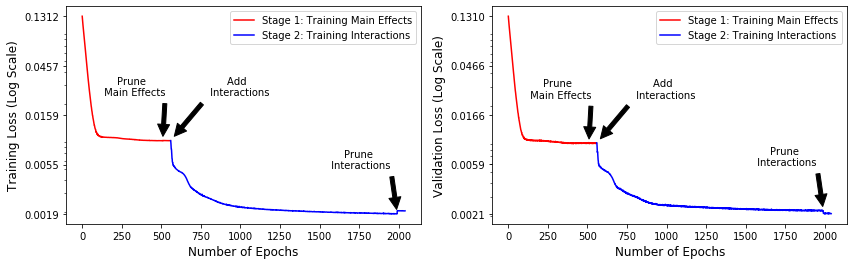

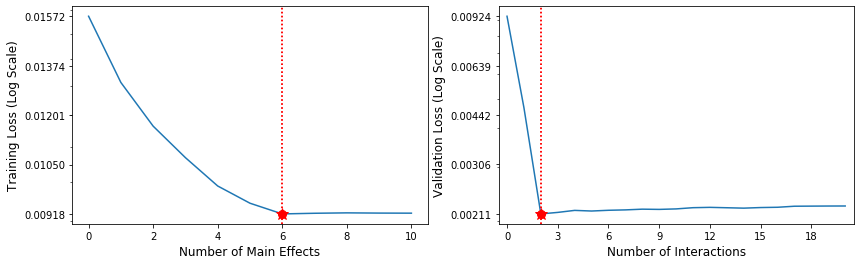

In [5]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

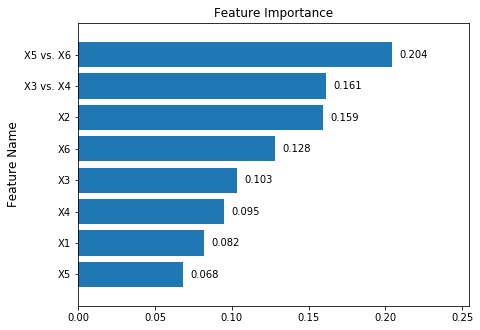

In [6]:
data_dict = model.global_explain(save_dict=False)
feature_importance_visualize(data_dict, save_png=True, folder=simu_dir, name='s1_feature')

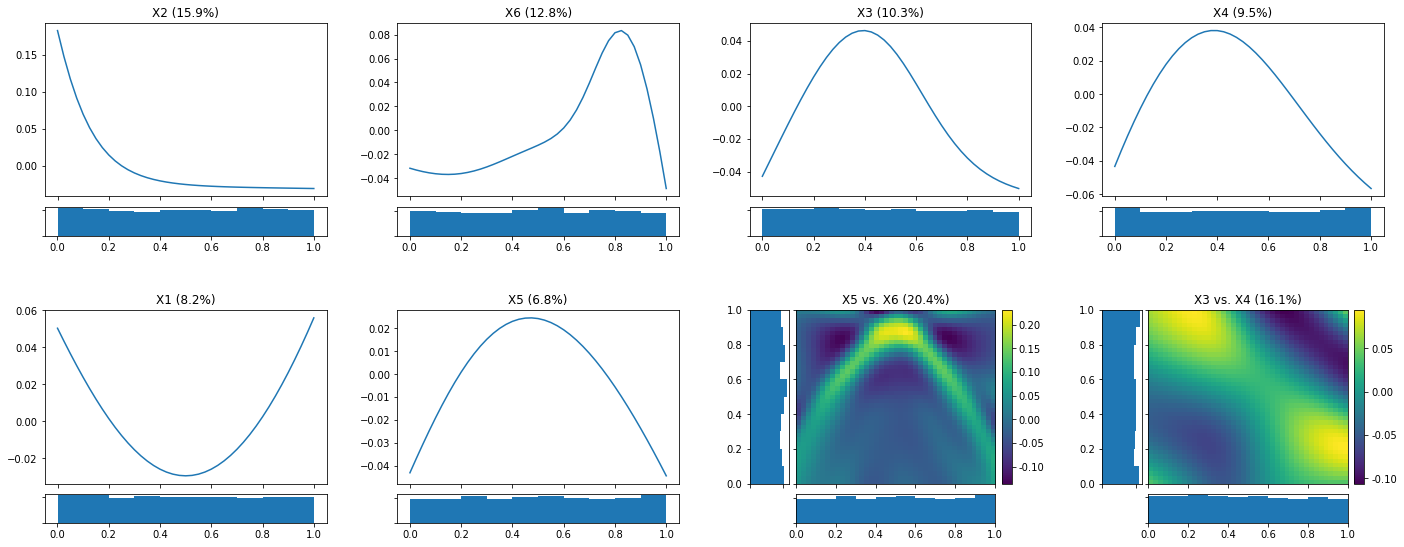

In [7]:
global_visualize_density(data_dict, save_png=True, folder=simu_dir, name='s1_global')

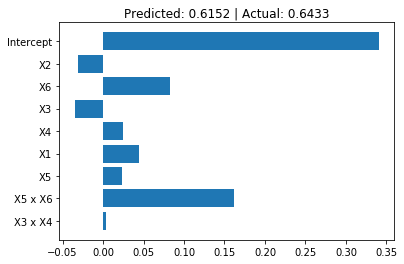

In [8]:
data_dict_local = model.local_explain(train_x[[0]], train_y[[0]], save_dict=False)
local_visualize(data_dict_local, save_png=True, folder=simu_dir, name='s1_local')